## This notebook presents the reproducible procedure that we followed in comparing the performance of Hybrid Quantum Neural Networks-Parallel and Classical Convolutional Neural Networks on the GlaucomaFundus dataset. The GlaucomaFundus dataset is a glaucoma-focused dataset with 1544 fundus images. The dataset was produced in South Korea and is labeled with three-category classification (Non-Glaucoma, Early Glaucoma, and Glaucoma).

### Installing and Importing Dependencies

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 80.8 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from google.colab import drive
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Sampler
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import time
import os
import copy
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve,
    precision_recall_curve, auc, ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize
import random
from itertools import cycle

os.environ["OMP_NUM_THREADS"] = "1"

In [ ]:
import matplotlib.pyplot as plt
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/GLAUCOMAFUNDUS_models_QNN-Parallel/"

### General Training, Validation, Testing Functions

In [ ]:
import torchvision
from torchvision import datasets, transforms

In [ ]:
def train_model(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_probs = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        probs = torch.softmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())



    avg_train_loss = train_loss / len(train_loader.dataset)
    accuracy = correct / total * 100

    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_train_loss, accuracy, avg_auroc

In [ ]:
def validate_model(model, valid_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader.dataset)
    accuracy = correct / total * 100
    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_val_loss, accuracy, avg_auroc

In [ ]:
import pickle

def train_validate_model(n_epochs, model, model_name, train_loader, valid_loader, seed, quantum=False):

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

  def adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max):
        if epoch < lr_warmup_epochs:
            lr = lr_max * (epoch + 1) / lr_warmup_epochs
        else:
            lr = lr_max
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

  scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs - 10, eta_min=1e-6)

  best_val_loss = float('inf')
  best_model_weights = model.state_dict()
  epochs_without_improvement = 0
  early_stopping_patience = 10

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []
  train_aucs = []
  val_aucs = []

  lr_max = 5e-4
  lr_warmup_epochs = 10

  for epoch in range(n_epochs):
      print(f'Epoch [{epoch+1}/{n_epochs}]')

      adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max)

      train_loss, train_accuracy, train_auroc = train_model(model, train_loader, optimizer, criterion)
      val_loss, val_accuracy, val_auroc = validate_model(model, valid_loader, criterion)


      print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Training AUROC: {train_auroc:.4f}')
      print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation AUROC: {val_auroc:.4f}')
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)
      train_aucs.append(train_auroc)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)
      val_aucs.append(val_auroc)

      if epoch >= lr_warmup_epochs:
            scheduler.step()

      if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            epochs_without_improvement = 0  # Reset counter

      else:
            epochs_without_improvement += 1

      if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break


  model.load_state_dict(best_model_weights)

  if quantum:
    torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}.pth'))
  else:
    torch.save(model, os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}.pth'))

  metrics = {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "train_aucs": train_aucs,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "val_aucs": val_aucs
    }

  with open(os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}_metrics.pkl'), 'wb') as f:
        pickle.dump(metrics, f)

  return model, train_losses, train_accuracies, val_losses, val_accuracies, train_aucs, val_aucs

In [ ]:
import math
import matplotlib.pyplot as plt

def plot(quantum_loss, normal_loss, quantum_acc, normal_acc, quantum_auc, normal_auc):
    plt.style.use("default")

    loss_min = math.floor(min(min(quantum_loss), min(normal_loss)) * 10) / 10
    loss_max = math.ceil(max(max(quantum_loss), max(normal_loss)) * 10) / 10

    acc_min = math.floor(min(min(quantum_acc), min(normal_acc)) * 10) / 10
    acc_max = math.ceil(max(max(quantum_acc), max(normal_acc)) * 10) / 10

    auc_min = math.floor(min(min(quantum_auc), min(normal_auc)) * 10) / 10
    auc_max = math.ceil(max(max(quantum_auc), max(normal_auc)) * 10) / 10

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_loss, label="With quantum layer")
    plt.plot(normal_loss, label="Without quantum layer")
    plt.ylabel("Loss")
    plt.ylim([loss_min, loss_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Loss vs. Epoch")
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_acc, label="With quantum layer")
    plt.plot(normal_acc, label="Without quantum layer")
    plt.ylabel("Accuracy")
    plt.ylim([acc_min, acc_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Accuracy vs. Epoch")
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.plot(quantum_auc, label="With quantum layer")
    plt.plot(normal_auc, label="Without quantum layer")
    plt.ylabel("ROCAUC")
    plt.ylim([auc_min, auc_max])
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("ROCAUC vs. Epoch")
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.preprocessing import label_binarize
from itertools import cycle


def test(model_hybrid, model_normal, test_loader, num_classes):
    model_hybrid.eval()
    model_normal.eval()

    all_labels = []
    all_preds_hybrid = []
    all_preds_normal = []
    all_probs_hybrid = []
    all_probs_normal = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)


            outputs_hybrid = model_hybrid(images)
            _, preds_hybrid = torch.max(outputs_hybrid, 1)
            probs_hybrid = torch.softmax(outputs_hybrid, dim=1)
            # Normal model predictions
            outputs_normal = model_normal(images)
            _, preds_normal = torch.max(outputs_normal, 1)
            probs_normal = torch.softmax(outputs_normal, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds_hybrid.extend(preds_hybrid.cpu().numpy())
            all_preds_normal.extend(preds_normal.cpu().numpy())
            all_probs_hybrid.extend(probs_hybrid.cpu().numpy())
            all_probs_normal.extend(probs_normal.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds_hybrid = np.array(all_preds_hybrid)
    all_preds_normal = np.array(all_preds_normal)
    all_probs_hybrid = np.array(all_probs_hybrid)
    all_probs_normal = np.array(all_probs_normal)


    accuracy_hybrid = accuracy_score(all_labels, all_preds_hybrid)
    accuracy_normal = accuracy_score(all_labels, all_preds_normal)


    f1_hybrid = f1_score(all_labels, all_preds_hybrid, average='weighted')
    f1_normal = f1_score(all_labels, all_preds_normal, average='weighted')


    if num_classes == 2:
        precision_hybrid = precision_score(all_labels, all_preds_hybrid, pos_label=1)
        recall_hybrid = recall_score(all_labels, all_preds_hybrid, pos_label=1)
        precision_normal = precision_score(all_labels, all_preds_normal, pos_label=1)
        recall_normal = recall_score(all_labels, all_preds_normal, pos_label=1)
    else:
        precision_hybrid = precision_score(all_labels, all_preds_hybrid, average='weighted')
        recall_hybrid = recall_score(all_labels, all_preds_hybrid, average='weighted')
        precision_normal = precision_score(all_labels, all_preds_normal, average='weighted')
        recall_normal = recall_score(all_labels, all_preds_normal, average='weighted')


    hybrid_aucs = []
    normal_aucs = []

    if num_classes == 2:

        all_probs_hybrid_class1 = all_probs_hybrid[:, 1]
        all_probs_normal_class1 = all_probs_normal[:, 1]

        auc_hybrid = roc_auc_score(all_labels, all_probs_hybrid_class1)
        auc_normal = roc_auc_score(all_labels, all_probs_normal_class1)

        print(f'Hybrid Model AUROC: {auc_hybrid:.4f}')
        print(f'Normal Model AUROC: {auc_normal:.4f}')

        fpr_hybrid, tpr_hybrid, _ = roc_curve(all_labels, all_probs_hybrid_class1)
        plt.figure(figsize=(10, 6))
        plt.plot(fpr_hybrid, tpr_hybrid, label=f'Hybrid Model AUROC = {auc_hybrid:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve - Hybrid Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

        # Plot ROC curve for the Normal Model
        fpr_normal, tpr_normal, _ = roc_curve(all_labels, all_probs_normal_class1)
        plt.figure(figsize=(10, 6))
        plt.plot(fpr_normal, tpr_normal, label=f'Normal Model AUROC = {auc_normal:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title('ROC Curve - Normal Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

    else:  # Multi-class Classification

        all_labels_binarized = label_binarize(all_labels, classes=np.arange(num_classes))

        # Define a color cycle for plotting
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
        # Plot ROC curves for the Hybrid Model
        plt.figure(figsize=(10, 8))
        for i, color in zip(range(num_classes), colors):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs_hybrid[:, i])
            roc_auc = auc(fpr, tpr)
            hybrid_aucs.append(roc_auc)
            plt.plot(fpr, tpr, color=color, lw=2,
                    label=f'Class {i} (AUC = {roc_auc:.2f})')


        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves - Hybrid Model')
        plt.legend(loc='lower right')
        plt.show()

        # Plot ROC curves for the Normal Model
        plt.figure(figsize=(10, 8))
        for i, color in zip(range(num_classes), colors):
            fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_probs_normal[:, i])
            roc_auc = auc(fpr, tpr)
            normal_aucs.append(roc_auc)
            plt.plot(fpr, tpr, color=color, lw=2,
                    label=f'Class {i} (AUC = {roc_auc:.2f})')


        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves - Normal Model')
        plt.legend(loc='lower right')
        plt.show()



    filtered_normal_aucs = [auc for auc in normal_aucs if auc > 0]
    filtered_hybrid_aucs = [auc for auc in hybrid_aucs if auc > 0]
    print(filtered_normal_aucs)
    print(filtered_hybrid_aucs)

    # Calculate average AUC, handling cases where all values might be zero
    normal_auc = f"{sum(filtered_normal_aucs) / len(filtered_normal_aucs):.4f}" if filtered_normal_aucs else "N/A"
    hybrid_auc = f"{sum(filtered_hybrid_aucs) / len(filtered_hybrid_aucs):.4f}" if filtered_hybrid_aucs else "N/A"

    print("\nHybrid Model Metrics:")
    print(f'Accuracy: {accuracy_hybrid:.4f}')
    print(f'F1 Score: {f1_hybrid:.4f}')
    print(f'Precision: {precision_hybrid:.4f}')
    print(f'Recall: {recall_hybrid:.4f}')
    print(f'AUROC: {hybrid_auc}')

    print("\nNormal Model Metrics:")
    print(f'Accuracy: {accuracy_normal:.4f}')
    print(f'F1 Score: {f1_normal:.4f}')
    print(f'Precision: {precision_normal:.4f}')
    print(f'Recall: {recall_normal:.4f}')
    print(f'AUROC: {normal_auc} \n')

    cm_hybrid = confusion_matrix(all_labels, all_preds_hybrid)


    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: Hybrid Model (Avg AUC = {hybrid_auc})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    cm_normal = confusion_matrix(all_labels, all_preds_normal)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_normal, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix: Classical Model (Avg AUC = {normal_auc})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
def load_data(batch_size, dataset):

  train_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  valid_test_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])


  if dataset == 'APTOS':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS2019/"

  elif dataset == "IDRID":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_images/"

  elif dataset == "Messidor":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR2/"

  elif dataset == "GlaucomaFundus":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Glaucoma_fundus/"

  elif dataset == "PAPILA":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA/"

  elif dataset == 'G1020':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020/"


  train_dataset = datasets.ImageFolder(root=data_dir + 'train', transform=train_transform)
  val_dataset = datasets.ImageFolder(root=data_dir + 'val', transform=valid_test_transform)
  test_dataset = datasets.ImageFolder(root=data_dir + 'test', transform=valid_test_transform)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
  valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

  return train_loader, valid_loader, test_loader

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

### Classical CNN Model Construction and General Methods

In [ ]:
class NormalModel(nn.Module):
    def __init__(self, num_classes):
        super(NormalModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 56 * 56, 120)
        self.fc2 = nn.Linear(120, 20)
        self.fc3 = nn.Linear(20, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Hybrid Quantum Neural Network Construction

In [ ]:
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [ ]:
n_qubits = 5
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

# Define the QLayer
n_layers = 3
weight_shapes = {"weights": (n_layers, n_qubits)}


In [ ]:
class QuantumHybridModel(nn.Module):
    def __init__(self, num_classes):
      super(QuantumHybridModel, self).__init__()
      self.conv1 = nn.Conv2d(3, 16, 5, stride=1, padding=2)
      self.bn1 = nn.BatchNorm2d(16)
      self.pool = nn.MaxPool2d(2, 2)
      self.conv2 = nn.Conv2d(16, 32, 5, stride=1, padding=2)
      self.bn2 = nn.BatchNorm2d(32)
      self.qlayer1 = qml.qnn.TorchLayer(qnode, weight_shapes)
      self.qlayer2 = qml.qnn.TorchLayer(qnode, weight_shapes)
      self.qlayer3 = qml.qnn.TorchLayer(qnode, weight_shapes)
      self.qlayer4 = qml.qnn.TorchLayer(qnode, weight_shapes)
      self.fc1 = nn.Linear(32 * 56 * 56, 120)
      self.fc2 = nn.Linear(120, 20)
      self.fc3 = nn.Linear(20, num_classes)

    def forward(self, x):
        # Propagate the input through the CNN layers
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        # Flatten the output from the convolutional layers
        x = x.view(x.size(0), -1)
        # Pass the output to the quantum layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x_1, x_2, x_3, x_4 = torch.split(x, 5, dim=1)
        x_1 = self.qlayer1(x_1)
        x_2 = self.qlayer2(x_2)
        x_3 = self.qlayer3(x_3)
        x_4 = self.qlayer4(x_4)
        x = torch.cat([x_1, x_2, x_3, x_4], axis=1)
        x = self.fc3(x)
        return x

# Experiments

In [ ]:
n_epochs = 100
num_classes = 3
batch_size = 32
dataset = "GlaucomaFundus"
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

## Experiments 1

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NormalModel(num_classes).to(device)
hybrid_model = QuantumHybridModel(num_classes).to(device)
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 15:


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.6991, Training Accuracy: 68.41%, Training AUROC: 0.8261
Validation Loss: 0.7017, Validation Accuracy: 69.72%, Validation AUROC: 0.8807
Epoch [2/100]
Training Loss: 0.5383, Training Accuracy: 77.70%, Training AUROC: 0.9026
Validation Loss: 0.5484, Validation Accuracy: 78.44%, Validation AUROC: 0.9082
Epoch [3/100]
Training Loss: 0.5093, Training Accuracy: 79.44%, Training AUROC: 0.9115
Validation Loss: 0.5457, Validation Accuracy: 78.44%, Validation AUROC: 0.9089
Epoch [4/100]
Training Loss: 0.4570, Training Accuracy: 81.07%, Training AUROC: 0.9289
Validation Loss: 0.4990, Validation Accuracy: 79.82%, Validation AUROC: 0.9265
Epoch [5/100]
Training Loss: 0.5029, Training Accuracy: 78.98%, Training AUROC: 0.9163
Validation Loss: 0.5831, Validation Accuracy: 75.69%, Validation AUROC: 0.9001
Epoch [6/100]
Training Loss: 0.4930, Training Accuracy: 78.86%, Training AUROC: 0.9136
Validation Loss: 0.6877, Validation Accuracy: 74.31%, Validation AUROC: 0.8897
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    quantum=True,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.0073, Training Accuracy: 65.62%, Training AUROC: 0.7139
Validation Loss: 0.9873, Validation Accuracy: 68.81%, Validation AUROC: 0.7950
Epoch [2/100]
Training Loss: 0.9740, Training Accuracy: 71.43%, Training AUROC: 0.7935
Validation Loss: 0.9656, Validation Accuracy: 71.10%, Validation AUROC: 0.8519
Epoch [3/100]
Training Loss: 0.9710, Training Accuracy: 68.76%, Training AUROC: 0.8213
Validation Loss: 0.9995, Validation Accuracy: 57.34%, Validation AUROC: 0.8117
Epoch [4/100]
Training Loss: 0.9799, Training Accuracy: 69.45%, Training AUROC: 0.8524
Validation Loss: 0.9803, Validation Accuracy: 69.72%, Validation AUROC: 0.8238
Epoch [5/100]
Training Loss: 0.9643, Training Accuracy: 71.78%, Training AUROC: 0.8500
Validation Loss: 0.9701, Validation Accuracy: 66.06%, Validation AUROC: 0.8087
Epoch [6/100]
Training Loss: 0.9522, Training Accuracy: 66.67%, Training AUROC: 0.8253
Validation Loss: 0.9334, Validation Accuracy: 70.18%, Validation AUROC: 0.8446
Epoc

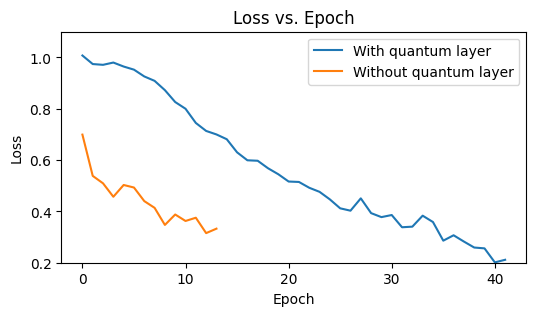

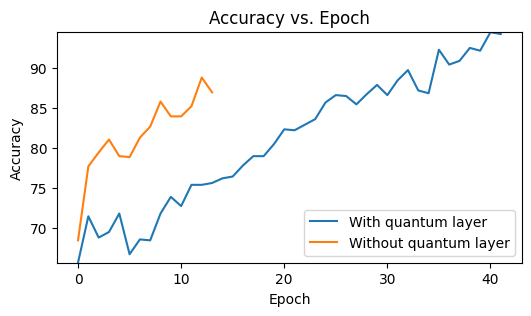

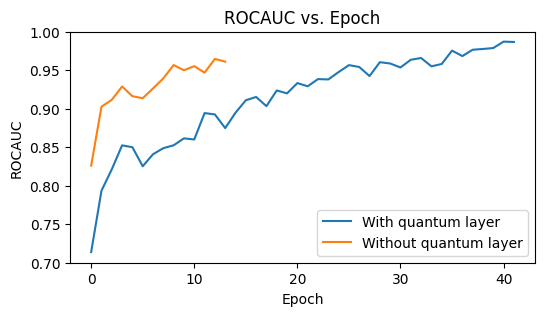

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

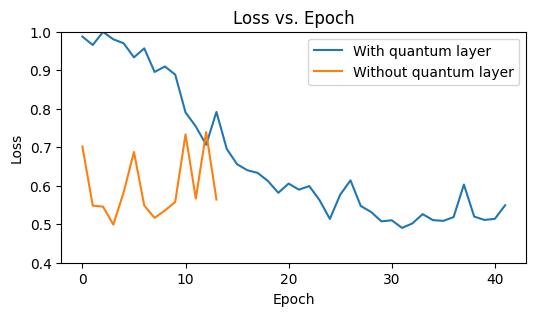

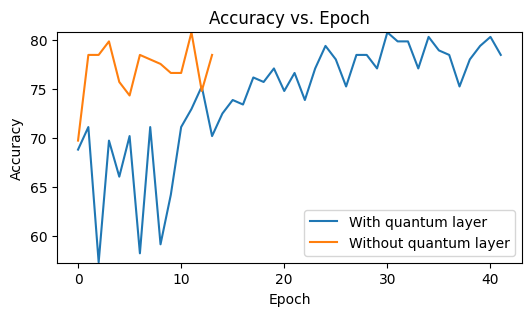

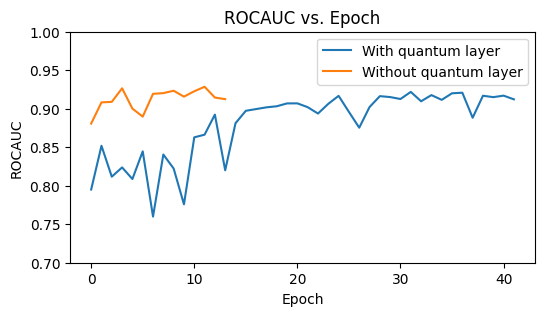

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

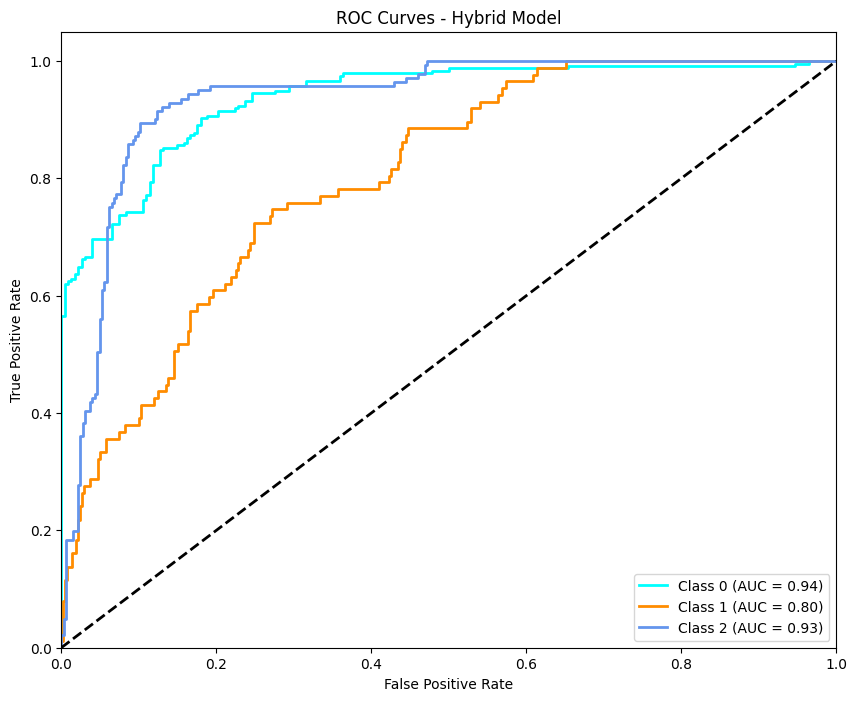

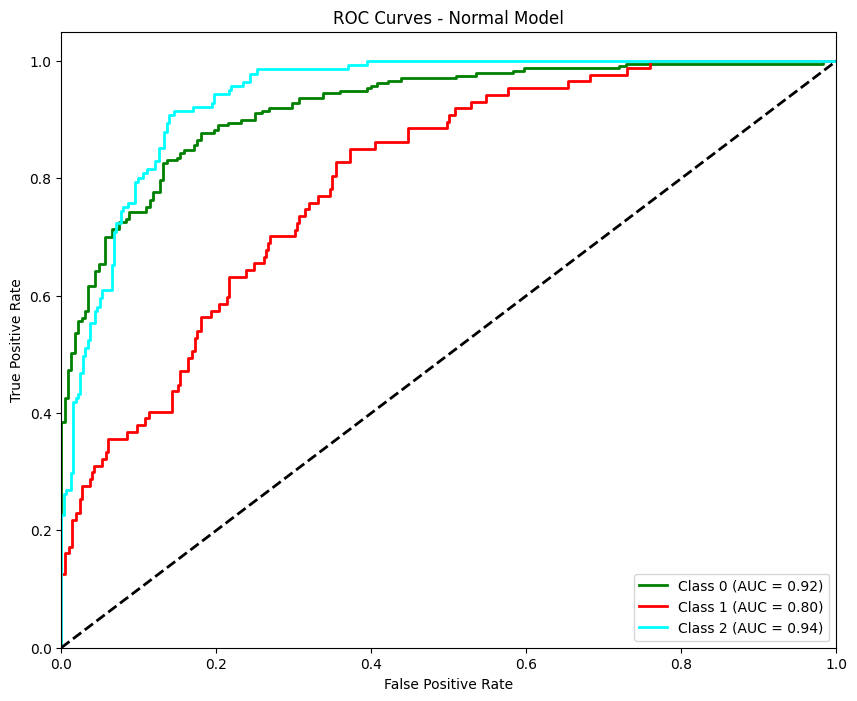

[0.9219594344511066, 0.7966611932129173, 0.9410515716662289]
[0.9375786512695241, 0.8021042388858481, 0.9349444006654408]

Hybrid Model Metrics:
Accuracy: 0.7720
F1 Score: 0.7650
Precision: 0.7657
Recall: 0.7720
AUROC: 0.8915

Normal Model Metrics:
Accuracy: 0.7226
F1 Score: 0.7348
Precision: 0.7603
Recall: 0.7226
AUROC: 0.8866 



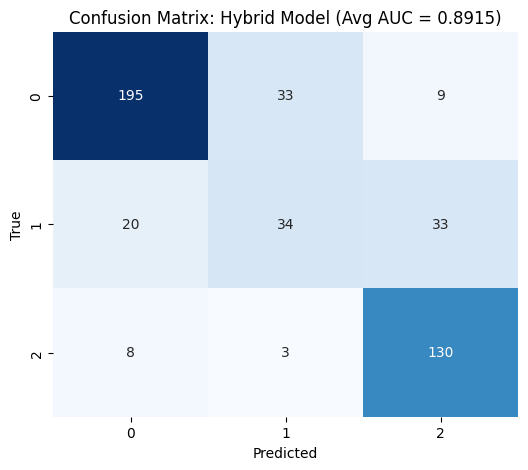

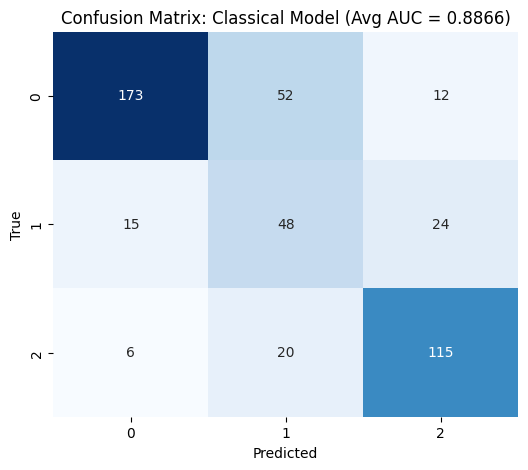

In [ ]:
test(hybrid_model, model, test_loader, num_classes=num_classes)

## Experiments 2

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NormalModel(num_classes).to(device)
hybrid_model = QuantumHybridModel(num_classes).to(device)
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 27:


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.7018, Training Accuracy: 68.06%, Training AUROC: 0.8236
Validation Loss: 0.7088, Validation Accuracy: 66.51%, Validation AUROC: 0.8497
Epoch [2/100]
Training Loss: 0.5883, Training Accuracy: 74.10%, Training AUROC: 0.8803
Validation Loss: 0.5745, Validation Accuracy: 71.56%, Validation AUROC: 0.8850
Epoch [3/100]
Training Loss: 0.5390, Training Accuracy: 76.07%, Training AUROC: 0.8975
Validation Loss: 0.5738, Validation Accuracy: 72.48%, Validation AUROC: 0.8871
Epoch [4/100]
Training Loss: 0.5011, Training Accuracy: 77.12%, Training AUROC: 0.9122
Validation Loss: 0.5673, Validation Accuracy: 75.23%, Validation AUROC: 0.9073
Epoch [5/100]
Training Loss: 0.6003, Training Accuracy: 74.33%, Training AUROC: 0.8842
Validation Loss: 0.5276, Validation Accuracy: 78.44%, Validation AUROC: 0.9112
Epoch [6/100]
Training Loss: 0.4748, Training Accuracy: 80.49%, Training AUROC: 0.9246
Validation Loss: 0.5843, Validation Accuracy: 74.31%, Validation AUROC: 0.9090
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    quantum=True,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.0208, Training Accuracy: 54.12%, Training AUROC: 0.7534
Validation Loss: 1.0176, Validation Accuracy: 61.47%, Validation AUROC: 0.8425
Epoch [2/100]
Training Loss: 0.9833, Training Accuracy: 62.37%, Training AUROC: 0.8354
Validation Loss: 0.9850, Validation Accuracy: 58.26%, Validation AUROC: 0.8468
Epoch [3/100]
Training Loss: 0.9756, Training Accuracy: 58.89%, Training AUROC: 0.8322
Validation Loss: 0.9806, Validation Accuracy: 56.42%, Validation AUROC: 0.8040
Epoch [4/100]
Training Loss: 0.9563, Training Accuracy: 59.58%, Training AUROC: 0.8367
Validation Loss: 0.9465, Validation Accuracy: 71.56%, Validation AUROC: 0.8351
Epoch [5/100]
Training Loss: 0.9247, Training Accuracy: 71.20%, Training AUROC: 0.8774
Validation Loss: 0.9304, Validation Accuracy: 65.14%, Validation AUROC: 0.8688
Epoch [6/100]
Training Loss: 0.9143, Training Accuracy: 68.64%, Training AUROC: 0.8564
Validation Loss: 0.9262, Validation Accuracy: 59.17%, Validation AUROC: 0.8506
Epoc

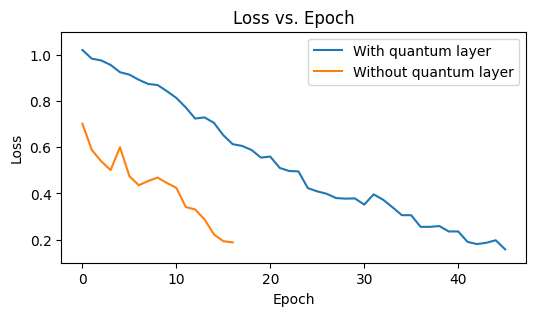

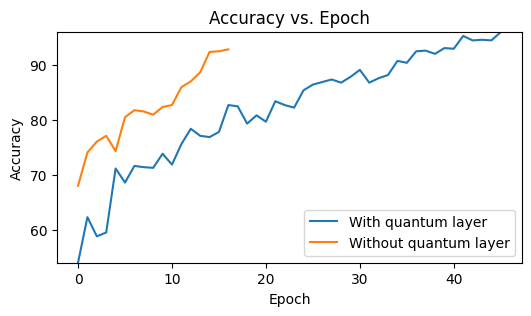

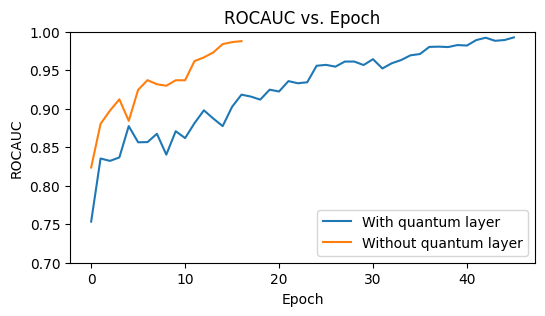

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

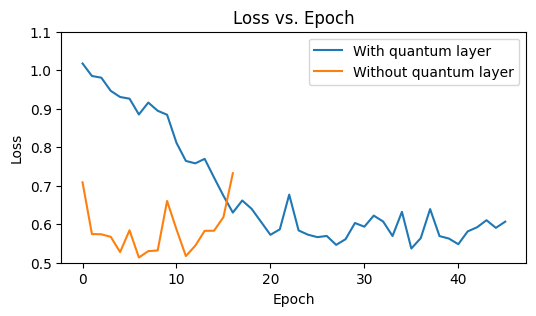

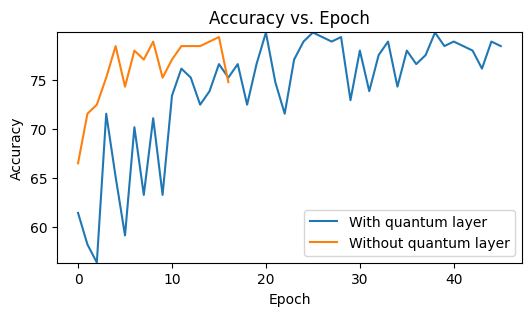

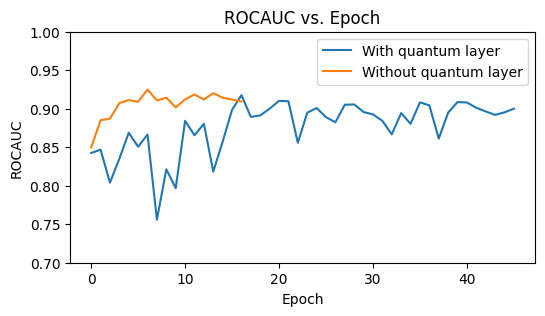

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

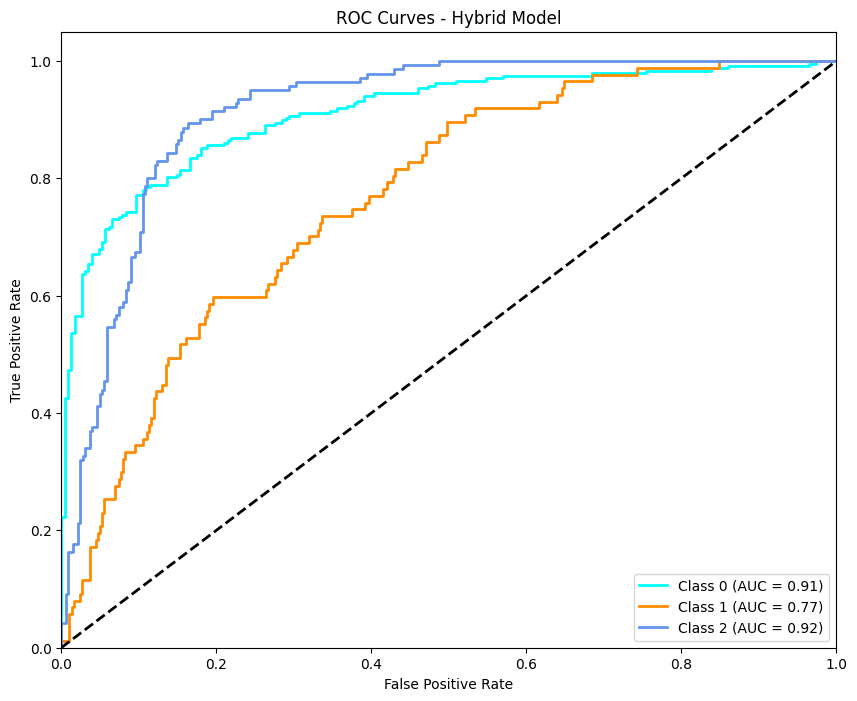

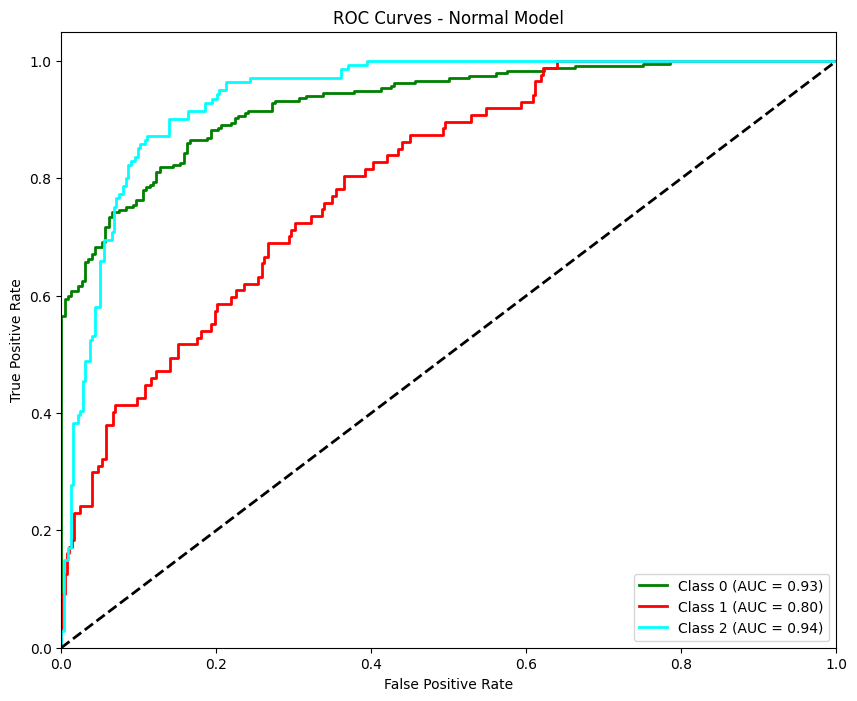

[0.9288622399881561, 0.7964179286018367, 0.941029682164434]
[0.911077799985195, 0.7682904579456303, 0.9156159705805096]

Hybrid Model Metrics:
Accuracy: 0.7398
F1 Score: 0.7407
Precision: 0.7532
Recall: 0.7398
AUROC: 0.8650

Normal Model Metrics:
Accuracy: 0.7269
F1 Score: 0.7330
Precision: 0.7583
Recall: 0.7269
AUROC: 0.8888 



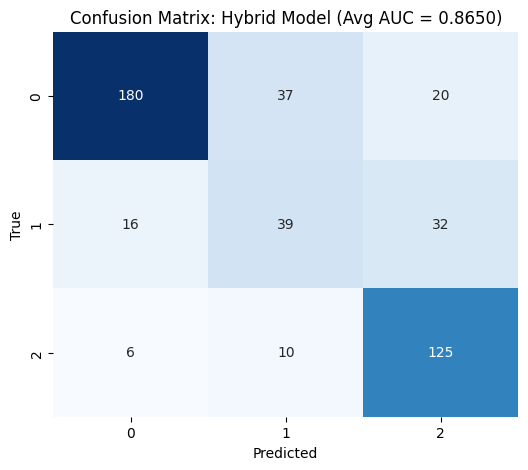

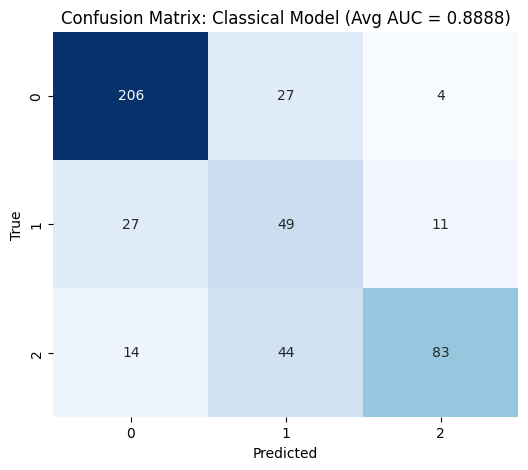

In [ ]:
test(hybrid_model, model, test_loader, num_classes=num_classes)

## Experiments 3

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NormalModel(num_classes).to(device)
hybrid_model = QuantumHybridModel(num_classes).to(device)
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 84:


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.7366, Training Accuracy: 65.04%, Training AUROC: 0.8025
Validation Loss: 0.7767, Validation Accuracy: 62.84%, Validation AUROC: 0.8291
Epoch [2/100]
Training Loss: 0.5846, Training Accuracy: 74.33%, Training AUROC: 0.8861
Validation Loss: 0.6088, Validation Accuracy: 72.94%, Validation AUROC: 0.8780
Epoch [3/100]
Training Loss: 0.5402, Training Accuracy: 76.07%, Training AUROC: 0.9027
Validation Loss: 0.7654, Validation Accuracy: 69.72%, Validation AUROC: 0.8730
Epoch [4/100]
Training Loss: 0.5867, Training Accuracy: 74.80%, Training AUROC: 0.8826
Validation Loss: 0.5549, Validation Accuracy: 72.48%, Validation AUROC: 0.9034
Epoch [5/100]
Training Loss: 0.5280, Training Accuracy: 77.70%, Training AUROC: 0.9078
Validation Loss: 0.6813, Validation Accuracy: 73.85%, Validation AUROC: 0.8913
Epoch [6/100]
Training Loss: 0.5395, Training Accuracy: 76.89%, Training AUROC: 0.9037
Validation Loss: 0.6023, Validation Accuracy: 74.31%, Validation AUROC: 0.9108
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    quantum=True,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.0237, Training Accuracy: 64.23%, Training AUROC: 0.7684
Validation Loss: 1.0370, Validation Accuracy: 66.06%, Validation AUROC: 0.7221
Epoch [2/100]
Training Loss: 0.9861, Training Accuracy: 74.80%, Training AUROC: 0.8424
Validation Loss: 1.0027, Validation Accuracy: 74.31%, Validation AUROC: 0.8616
Epoch [3/100]
Training Loss: 0.9880, Training Accuracy: 74.56%, Training AUROC: 0.8609
Validation Loss: 0.9702, Validation Accuracy: 73.39%, Validation AUROC: 0.9058
Epoch [4/100]
Training Loss: 0.9634, Training Accuracy: 76.66%, Training AUROC: 0.8837
Validation Loss: 0.9703, Validation Accuracy: 70.18%, Validation AUROC: 0.8503
Epoch [5/100]
Training Loss: 0.9455, Training Accuracy: 78.05%, Training AUROC: 0.9007
Validation Loss: 0.9489, Validation Accuracy: 74.31%, Validation AUROC: 0.8793
Epoch [6/100]
Training Loss: 0.9335, Training Accuracy: 76.77%, Training AUROC: 0.8771
Validation Loss: 0.9431, Validation Accuracy: 72.02%, Validation AUROC: 0.7989
Epoc

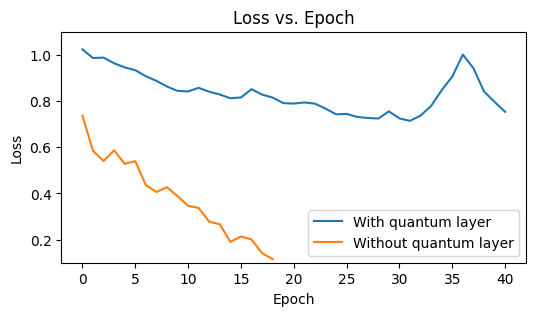

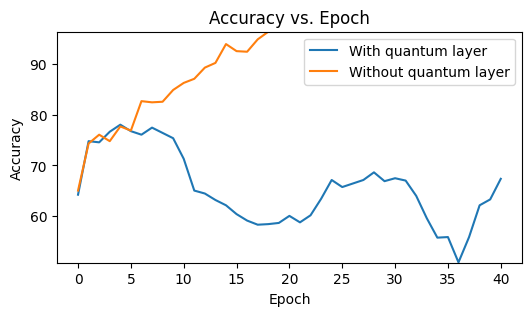

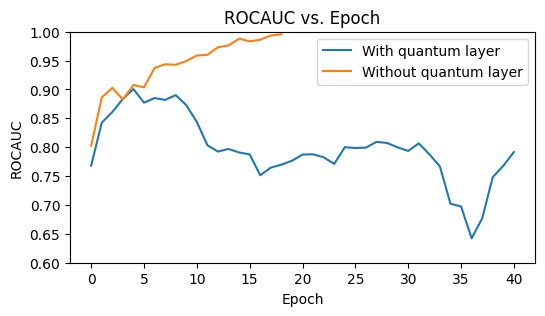

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

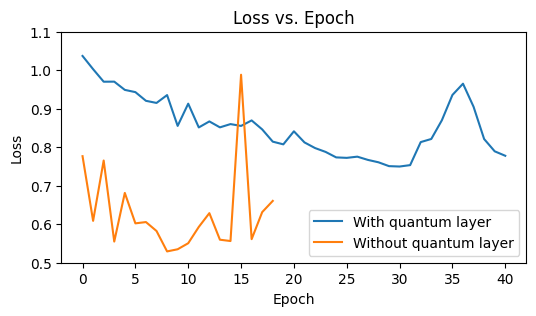

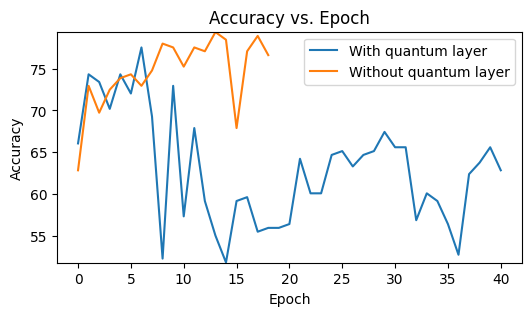

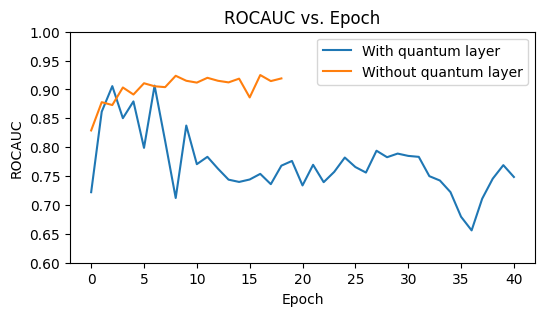

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


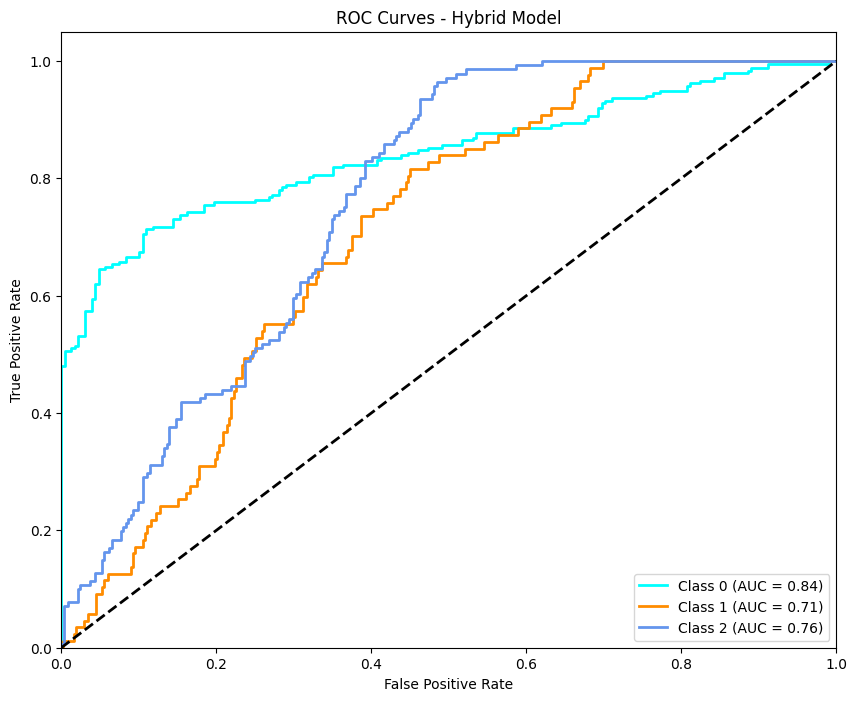

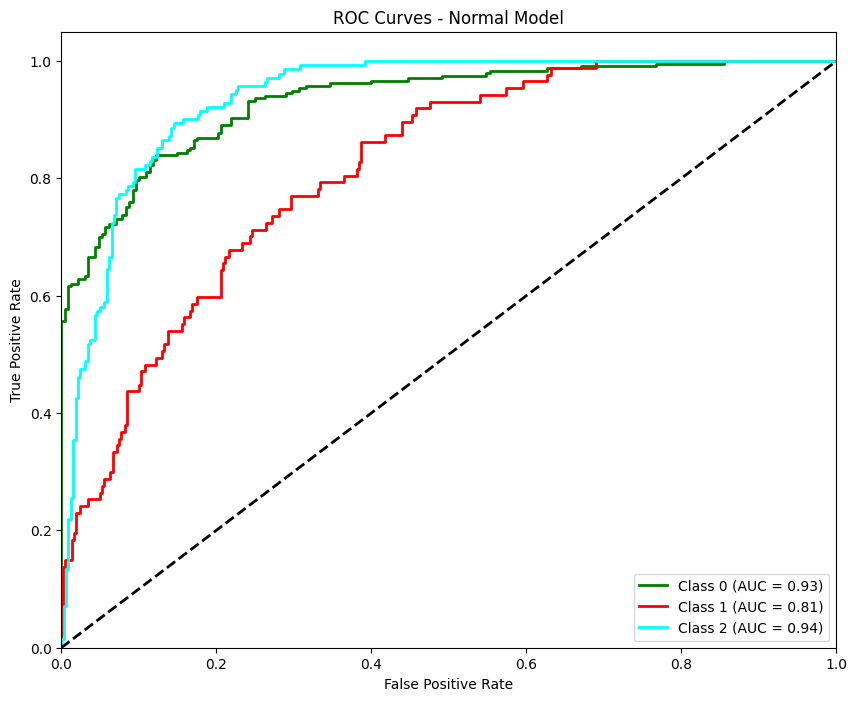

[0.9333222296246947, 0.814510734050964, 0.9384029419490413]
[0.8424938929602488, 0.7068357355713678, 0.7598721653095175]

Hybrid Model Metrics:
Accuracy: 0.6387
F1 Score: 0.5875
Precision: 0.5816
Recall: 0.6387
AUROC: 0.7697

Normal Model Metrics:
Accuracy: 0.7355
F1 Score: 0.7480
Precision: 0.7733
Recall: 0.7355
AUROC: 0.8954 



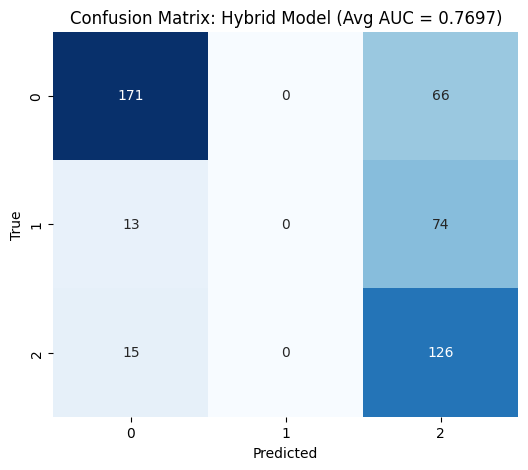

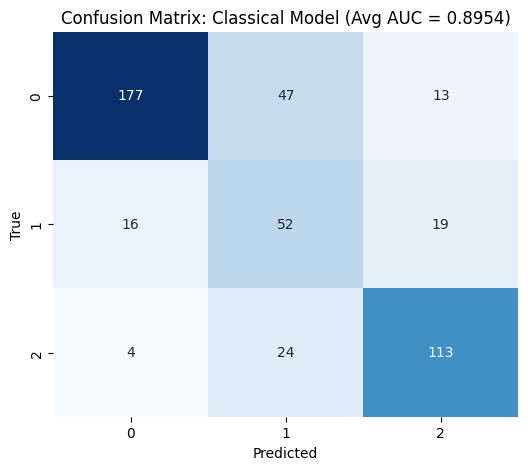

In [ ]:
test(hybrid_model, model, test_loader, num_classes=num_classes)

## Experiments 4

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NormalModel(num_classes).to(device)
hybrid_model = QuantumHybridModel(num_classes).to(device)
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 94:


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.7656, Training Accuracy: 64.34%, Training AUROC: 0.7972
Validation Loss: 0.7405, Validation Accuracy: 65.60%, Validation AUROC: 0.8367
Epoch [2/100]
Training Loss: 0.6110, Training Accuracy: 72.01%, Training AUROC: 0.8681
Validation Loss: 0.5997, Validation Accuracy: 72.02%, Validation AUROC: 0.8919
Epoch [3/100]
Training Loss: 0.5511, Training Accuracy: 75.84%, Training AUROC: 0.8976
Validation Loss: 0.5709, Validation Accuracy: 74.77%, Validation AUROC: 0.8937
Epoch [4/100]
Training Loss: 0.5278, Training Accuracy: 77.00%, Training AUROC: 0.9055
Validation Loss: 0.5735, Validation Accuracy: 72.48%, Validation AUROC: 0.9076
Epoch [5/100]
Training Loss: 0.5248, Training Accuracy: 79.91%, Training AUROC: 0.9080
Validation Loss: 0.4966, Validation Accuracy: 78.44%, Validation AUROC: 0.9261
Epoch [6/100]
Training Loss: 0.4714, Training Accuracy: 80.95%, Training AUROC: 0.9247
Validation Loss: 0.7548, Validation Accuracy: 70.64%, Validation AUROC: 0.9131
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    quantum=True,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.1052, Training Accuracy: 30.55%, Training AUROC: 0.6642
Validation Loss: 1.1177, Validation Accuracy: 31.65%, Validation AUROC: 0.6529
Epoch [2/100]
Training Loss: 1.0617, Training Accuracy: 33.22%, Training AUROC: 0.7060
Validation Loss: 1.0457, Validation Accuracy: 36.24%, Validation AUROC: 0.7678
Epoch [3/100]
Training Loss: 1.0458, Training Accuracy: 39.26%, Training AUROC: 0.7509
Validation Loss: 1.0457, Validation Accuracy: 54.13%, Validation AUROC: 0.7168
Epoch [4/100]
Training Loss: 1.0436, Training Accuracy: 60.63%, Training AUROC: 0.7189
Validation Loss: 1.0512, Validation Accuracy: 59.63%, Validation AUROC: 0.7640
Epoch [5/100]
Training Loss: 1.0374, Training Accuracy: 64.69%, Training AUROC: 0.7377
Validation Loss: 1.0282, Validation Accuracy: 68.35%, Validation AUROC: 0.7111
Epoch [6/100]
Training Loss: 1.0025, Training Accuracy: 73.17%, Training AUROC: 0.7932
Validation Loss: 1.0087, Validation Accuracy: 67.43%, Validation AUROC: 0.6976
Epoc

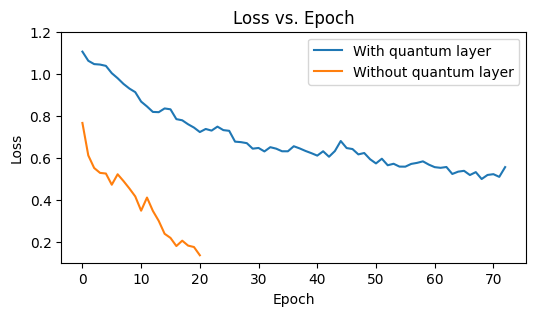

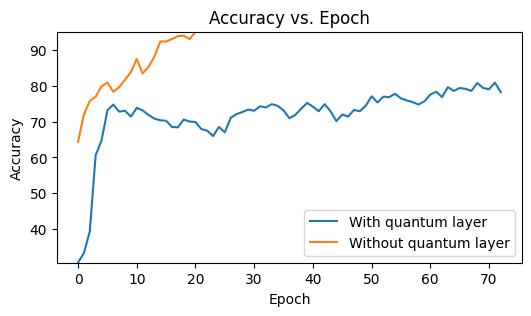

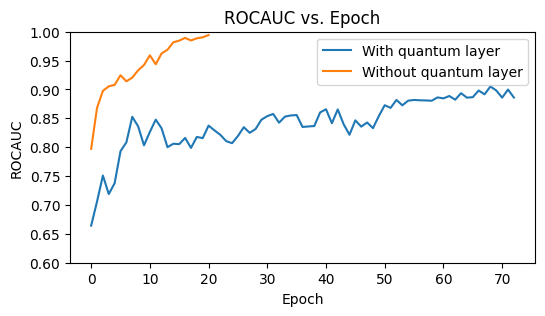

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

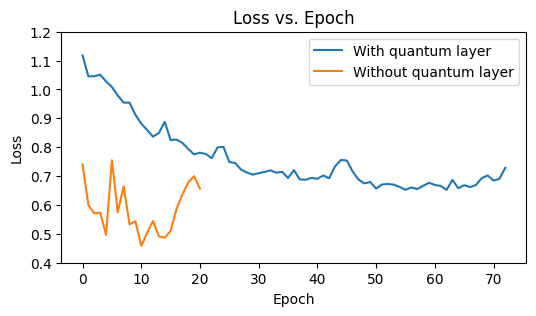

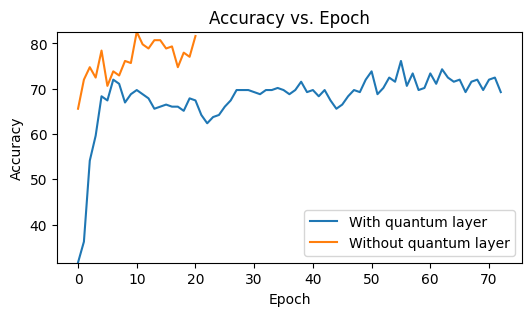

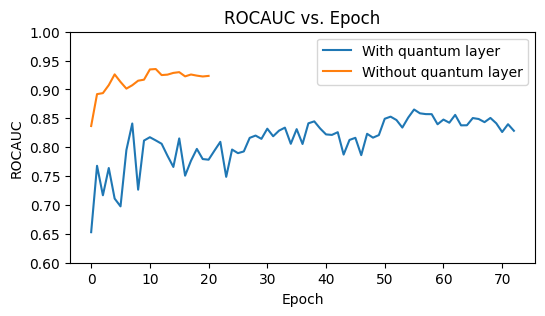

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

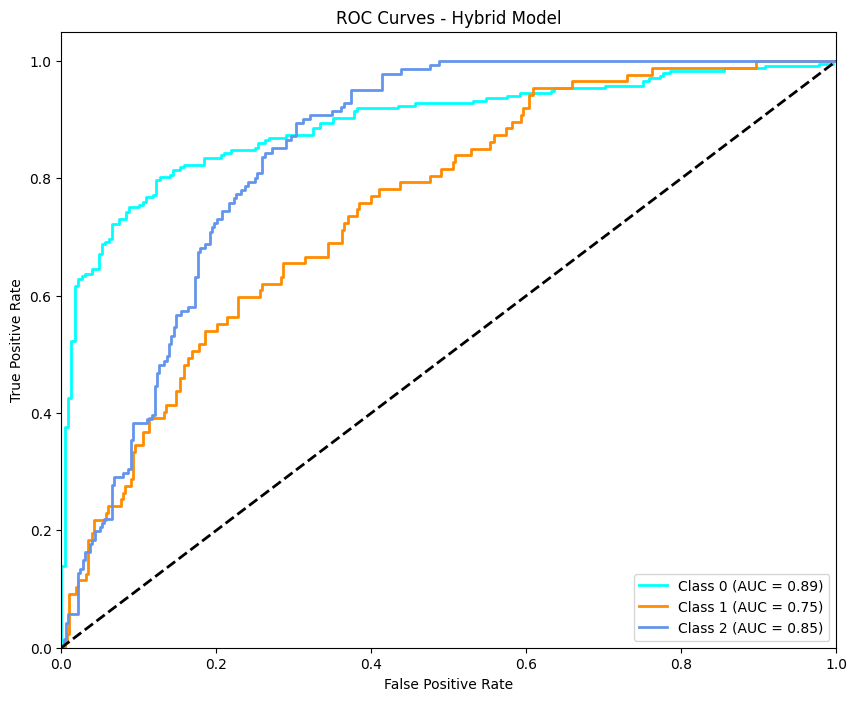

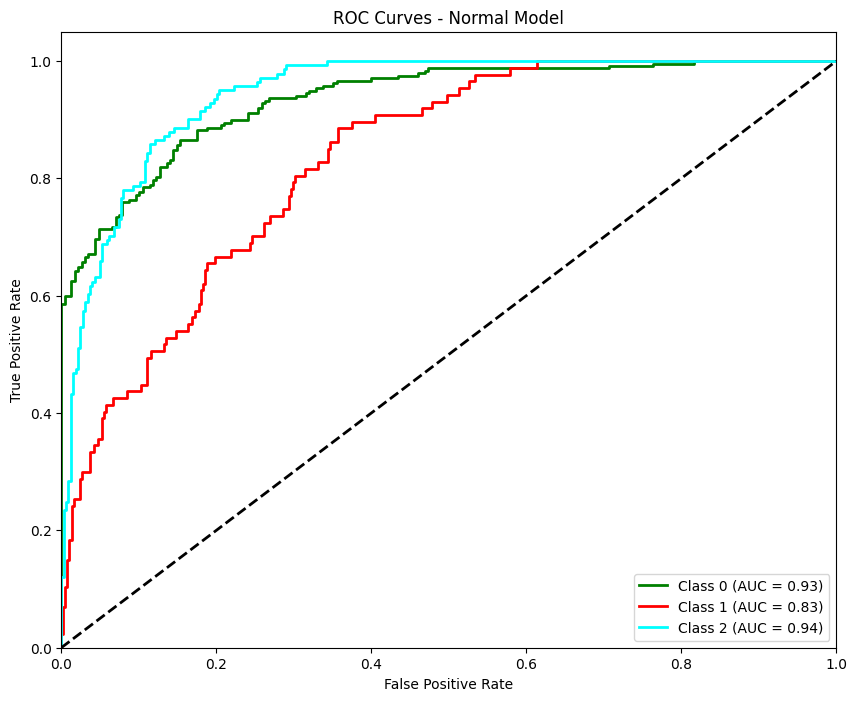

[0.9348582426530462, 0.8320561941251596, 0.9449260134839332]
[0.8943667184839736, 0.7513531593991364, 0.8451098852990105]

Hybrid Model Metrics:
Accuracy: 0.6839
F1 Score: 0.6628
Precision: 0.6582
Recall: 0.6839
AUROC: 0.8303

Normal Model Metrics:
Accuracy: 0.7548
F1 Score: 0.7599
Precision: 0.7713
Recall: 0.7548
AUROC: 0.9039 



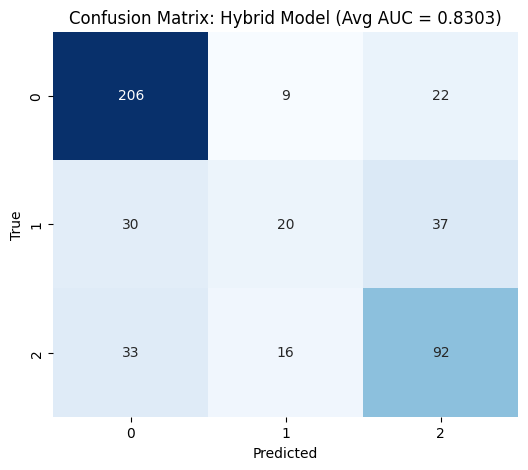

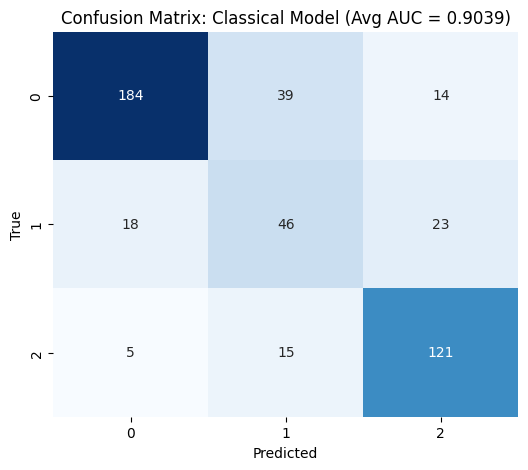

In [ ]:
test(hybrid_model, model, test_loader, num_classes=num_classes)

## Experiments 5

In [ ]:
seed = random.randint(1, 100)
print(f"Experiment with Seed {seed}:")
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NormalModel(num_classes).to(device)
hybrid_model = QuantumHybridModel(num_classes).to(device)
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Experiment with Seed 70:


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.7055, Training Accuracy: 67.13%, Training AUROC: 0.8151
Validation Loss: 0.7561, Validation Accuracy: 62.84%, Validation AUROC: 0.8267
Epoch [2/100]
Training Loss: 0.6316, Training Accuracy: 72.59%, Training AUROC: 0.8544
Validation Loss: 0.6048, Validation Accuracy: 75.23%, Validation AUROC: 0.8900
Epoch [3/100]
Training Loss: 0.5162, Training Accuracy: 78.40%, Training AUROC: 0.9081
Validation Loss: 0.5475, Validation Accuracy: 76.61%, Validation AUROC: 0.9119
Epoch [4/100]
Training Loss: 0.4924, Training Accuracy: 76.77%, Training AUROC: 0.9126
Validation Loss: 0.6539, Validation Accuracy: 74.77%, Validation AUROC: 0.9049
Epoch [5/100]
Training Loss: 0.4620, Training Accuracy: 80.26%, Training AUROC: 0.9295
Validation Loss: 0.5857, Validation Accuracy: 75.23%, Validation AUROC: 0.9149
Epoch [6/100]
Training Loss: 0.4163, Training Accuracy: 82.93%, Training AUROC: 0.9426
Validation Loss: 0.5044, Validation Accuracy: 78.90%, Validation AUROC: 0.9237
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    quantum=True,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.0423, Training Accuracy: 57.84%, Training AUROC: 0.7208
Validation Loss: 1.0383, Validation Accuracy: 67.43%, Validation AUROC: 0.7065
Epoch [2/100]
Training Loss: 1.0100, Training Accuracy: 71.78%, Training AUROC: 0.8044
Validation Loss: 1.0081, Validation Accuracy: 70.18%, Validation AUROC: 0.7980
Epoch [3/100]
Training Loss: 1.0084, Training Accuracy: 72.36%, Training AUROC: 0.7961
Validation Loss: 1.0078, Validation Accuracy: 66.97%, Validation AUROC: 0.7706
Epoch [4/100]
Training Loss: 1.0002, Training Accuracy: 71.43%, Training AUROC: 0.8138
Validation Loss: 1.0073, Validation Accuracy: 69.27%, Validation AUROC: 0.7702
Epoch [5/100]
Training Loss: 0.9908, Training Accuracy: 74.22%, Training AUROC: 0.8288
Validation Loss: 1.0110, Validation Accuracy: 66.51%, Validation AUROC: 0.8604
Epoch [6/100]
Training Loss: 0.9736, Training Accuracy: 75.26%, Training AUROC: 0.8627
Validation Loss: 0.9749, Validation Accuracy: 67.89%, Validation AUROC: 0.8377
Epoc

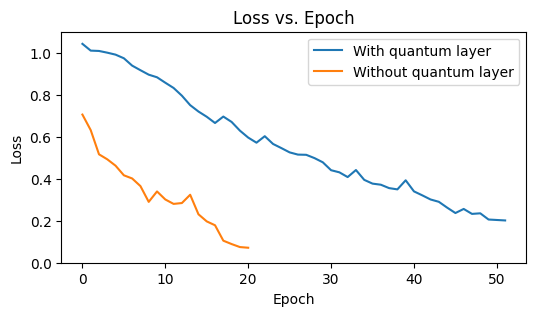

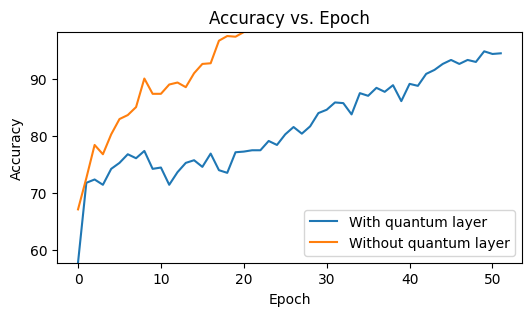

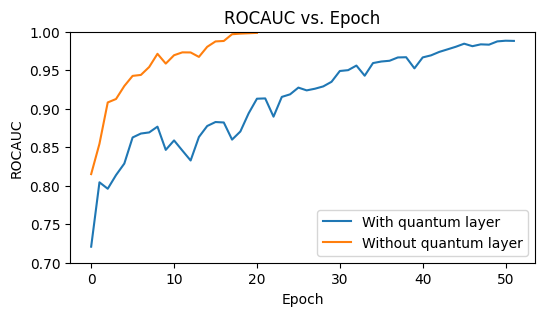

In [ ]:
plot(hybrid_train_losses, normal_train_losses, hybrid_train_accs, normal_train_accs, hybrid_train_aucs, normal_train_aucs)

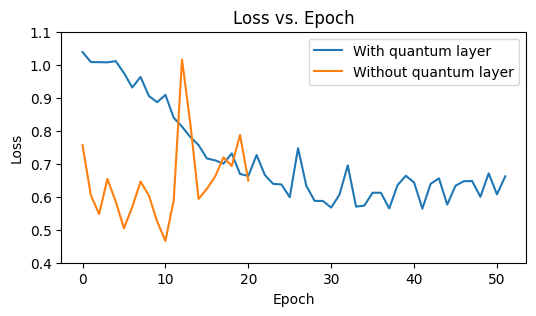

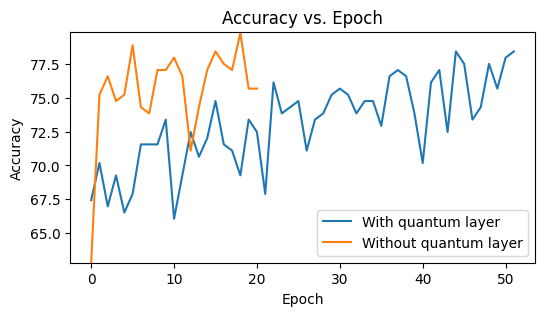

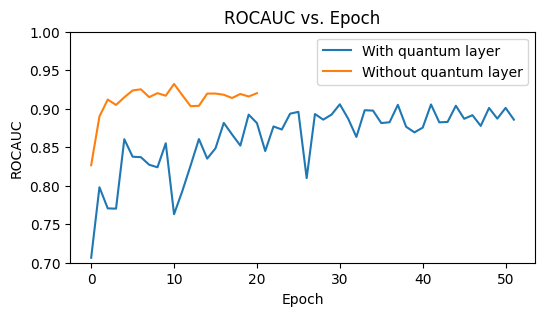

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

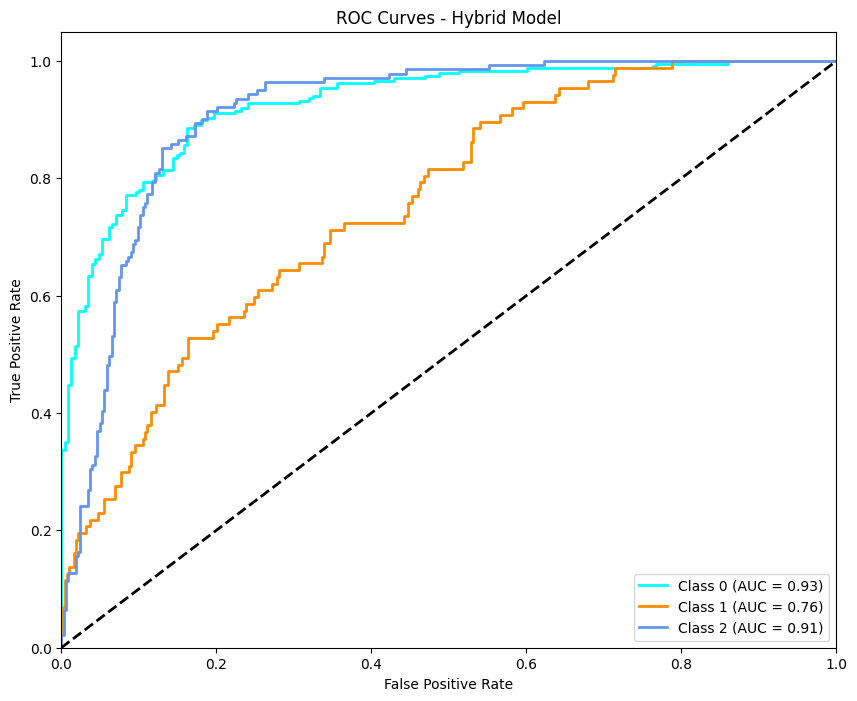

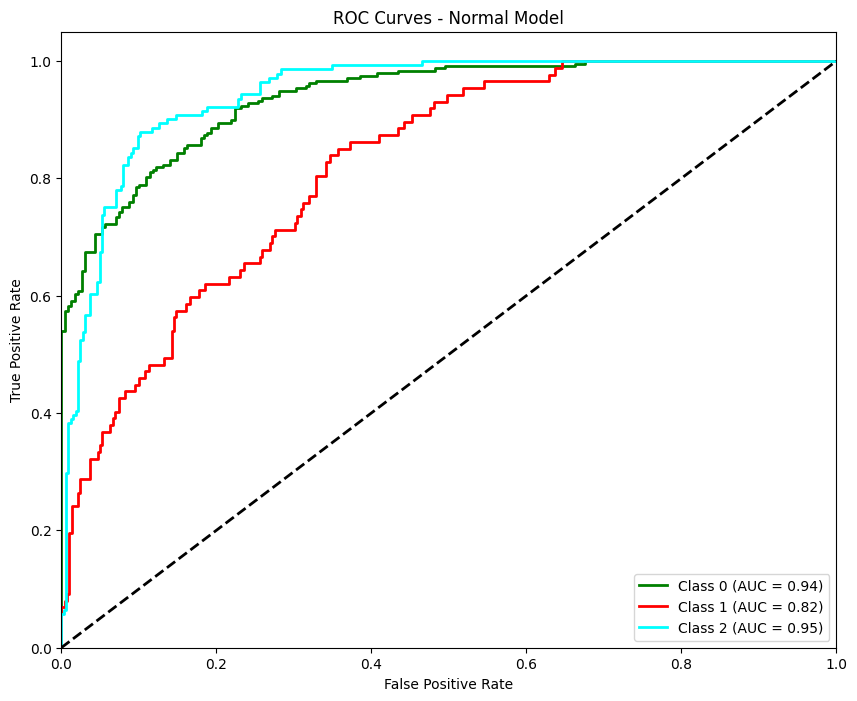

[0.9381153305203938, 0.8192848020434228, 0.9454294720252167]
[0.9281404989266415, 0.7557319223985891, 0.9124419928202434]

Hybrid Model Metrics:
Accuracy: 0.7419
F1 Score: 0.7239
Precision: 0.7254
Recall: 0.7419
AUROC: 0.8654

Normal Model Metrics:
Accuracy: 0.7591
F1 Score: 0.7620
Precision: 0.7654
Recall: 0.7591
AUROC: 0.9009 



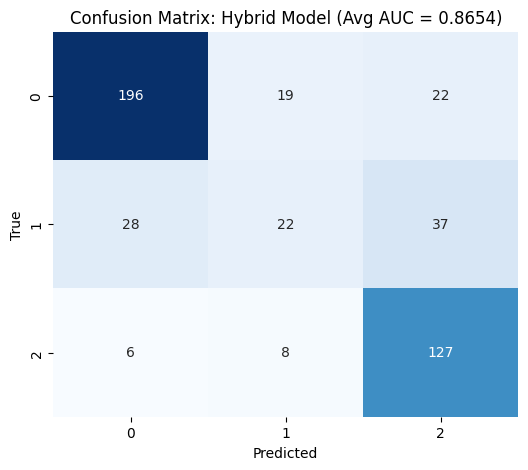

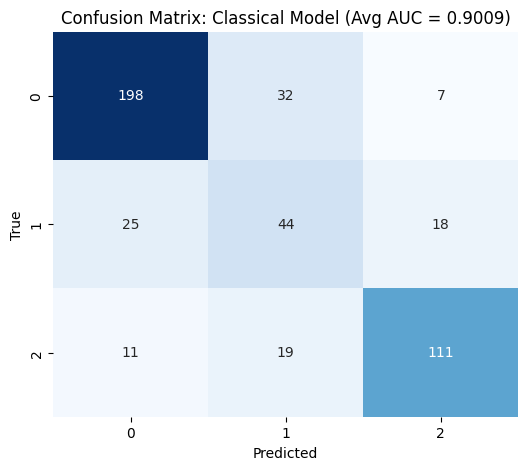

In [ ]:
test(hybrid_model, model, test_loader, num_classes=num_classes)